# 11. `flox`：進階的分組與重抽樣套件

Flox 是一個專為xarray與dask設計的 **分組 (groupby) 套件**。事實上，xarray 內建的 `groupby` 函數就是由 Flox 驅動的。直接使用 Flox 可以帶來更高的彈性，特別是在處理大型資料或需要自訂分組邏輯時。在本章中，我們將著重於示範如何在xarray 的工作流程中使用 Flox。

[`flox.xarray.xarray_reduce`](https://flox.readthedocs.io/en/latest/generated/flox.xarray.xarray_reduce.html) 的語法如下： 

```
flox.xarray.xarray_reduce(obj, *by, func, expected_groups=None, isbin=False, sort=True, dim=None, fill_value=None, dtype=None, method=None, engine=None, keep_attrs=True, skipna=None, min_count=None, reindex=None, **finalize_kwargs)
```

我們會用幾個實際的範例來示範怎麼設定。

**Example 1:** 利用flox計算OLR的月氣候平均。

In [1]:
import xarray as xr 
import numpy as np
from flox.xarray import xarray_reduce 

olr = xr.open_dataset('./data/olr.nc').olr
olr

<xarray.DataArray 'olr' (time: 8760, lat: 90, lon: 360)> Size: 1GB
[283824000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 360B -44.5 -43.5 -42.5 -41.5 ... 41.5 42.5 43.5 44.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

In [2]:
olr_MonClim = xarray_reduce(olr, 
                            olr.time.dt.month,
                            func='nanmean',
                            isbin=False,
                            dim='time')
olr_MonClim

<xarray.DataArray 'olr' (month: 12, lat: 90, lon: 360)> Size: 2MB
array([[[225.58421, 225.62595, 225.36943, ..., 225.83441, 225.85898,
         225.92003],
        [228.00739, 227.9622 , 227.851  , ..., 228.10371, 228.09421,
         227.95262],
        [231.18974, 231.17189, 231.44382, ..., 230.89458, 230.95192,
         231.03725],
        ...,
        [214.19003, 214.14554, 218.11049, ..., 215.3506 , 216.68962,
         215.23729],
        [214.91034, 215.55283, 216.19458, ..., 217.32828, 215.91357,
         214.31436],
        [215.02695, 214.27896, 213.24168, ..., 219.63155, 218.54819,
         215.31064]],

       [[227.02782, 227.04176, 227.09473, ..., 226.90578, 227.03078,
         227.02371],
        [230.04054, 230.17659, 230.02512, ..., 229.74895, 230.0428 ,
         230.08795],
        [233.30995, 233.28314, 233.47632, ..., 233.01225, 233.09662,
         233.23367],
...
        [219.23103, 219.16414, 222.37744, ..., 219.44844, 221.038  ,
         219.97647],
        [219.36812, 220.15967, 220.03369, ..., 221.9813 , 220.29796,
         218.5923 ],
        [219.94093, 219.25873, 217.4633 , ..., 224.98749, 223.33781,
         219.8922 ]],

       [[223.5979 , 223.45673, 223.35814, ..., 223.87383, 223.8027 ,
         223.70549],
        [225.48326, 225.7224 , 225.6315 , ..., 225.50816, 225.35074,
         225.41876],
        [227.75345, 228.0026 , 228.32658, ..., 227.2579 , 227.65778,
         227.7984 ],
        ...,
        [215.4115 , 215.50542, 219.62431, ..., 215.82678, 217.10307,
         216.24318],
        [216.39676, 217.10167, 217.78094, ..., 218.50357, 216.9284 ,
         215.58885],
        [216.76573, 216.4303 , 215.08284, ..., 220.95834, 219.71165,
         216.29623]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float32 360B -44.5 -43.5 -42.5 -41.5 ... 41.5 42.5 43.5 44.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

- `olr`: 為 `DataArray` 變數，我們要計算這個變數的氣候平均。
- `olr.time.dt.month`: 將資料分組的根據，flox會按照這個組別分類。
- `func='nanmean'`: 針對各個組別，進行統計運算的方法。Flox支援不同的統計函數如下：  
  “all”, “any”, “count”, “sum”, “nansum”, “mean”, “nanmean”,  
  “max”, “nanmax”, “min”, “nanmin”, “argmax”, “nanargmax”,  
  “argmin”, “nanargmin”, “quantile”, “nanquantile”,  
  “median”, “nanmedian”, “mode”, “nanmode”,  
  “first”, “nanfirst”, “last”, “nanlast”
- `isbin`: 決定是否要按照`expected_groups`定義的資料區間進行分組。在這個範例，我們只是按照資料時間的月份進行分組，是資料中的數值 (即12個月份)，因此設定為`False`。後續的範例會在介紹要設定為`True`的情形。 
- `dim='time'`: 指定要根據哪些資料軸進行統計計算。這裡是針對時間軸進行平均。


**Example 2: 一維機率分布函數。** 計算日降雨的機率分布函數。

**Step 1:** 讀資料。

In [3]:
pcp = xr.open_dataarray('./data/cmorph_sample.nc').sel(lat=slice(-15,15),lon=slice(90,160))
pcp_djf = pcp.sel(time=pcp.time.dt.month.isin([12,1,2]))
pcp_djf

<xarray.DataArray 'cmorph' (time: 2166, lat: 120, lon: 280)> Size: 291MB
[72777600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 17kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 1kB 90.12 90.38 90.62 90.88 ... 159.4 159.6 159.9
  * lat      (lat) float32 480B -14.88 -14.62 -14.38 ... 14.38 14.62 14.88
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      precipitation
    units:          mm/day
    ver_note:       1998-2020: V1,0; 2021: V0.x.
    comment:        !!! CMORPH estimate is rainrate !!!

**Step 2:** 利用`flox`計算每個降雨資料區間的出現次數。從`flox`技術上來說，降雨DataArray會依據降雨資料的值進行分組。

In [4]:
pdf = xarray_reduce(pcp_djf,
                    pcp_djf,
                    func='count',
                    isbin=True,
                    expected_groups=np.geomspace(0.5, 50, 20),
                    dim=['time','lat','lon'])
pdf_percent = pdf / pdf.sum() * 100.
pdf_percent

<xarray.DataArray 'cmorph' (cmorph_bins: 19)> Size: 152B
array([3.09464685, 4.98283472, 4.17693794, 5.09792383, 4.33013187,
       5.83681144, 5.57525959, 5.37691207, 6.11883881, 5.90911831,
       5.98125898, 6.33805064, 6.27095539, 6.25657   , 6.10623415,
       5.71656116, 5.11653848, 4.35264337, 3.36177241])
Coordinates:
  * cmorph_bins  (cmorph_bins) object 152B (0.5, 0.6371374928515668] ... (39....

- `pcp_djf`：要被分組的 `DataArray` 變數。由於我們要按照 `pcp_djf` 的數值進行分類，所以第二個參數 (`by` argument) 也同樣指定為 `pcp_djf`。  
- `func='count'`：統計方法為 `count`，表示計算降雨數值落在各個資料區間的次數。  
- `isbin=True`：代表按照`expected_groups`中定義的資料區間進行分組，而不是依據所有降雨資料的實際值逐一分組。  
- `expected_groups=np.geomspace(0.1, 50, 20)`：設定分組的區間。我們使用對數間距 (`geomspace`)，因為降雨數值通常呈現對數分布。  
- `dim=['time','lat','lon']`：將時間與空間維度 (`time`, `lat`, `lon`) 都納入統計，因此最後得到一維機率分布函數。  

Text(0.5, 0, 'Rain rate (mm day$^{-1}$)')

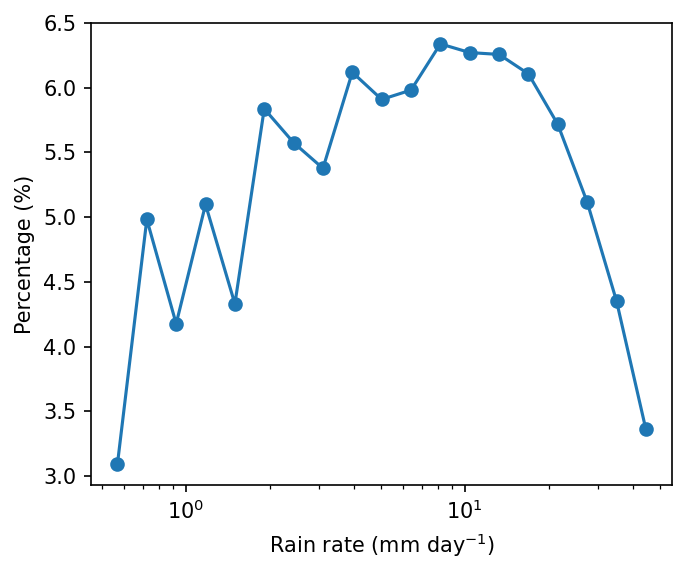

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots(figsize=(5,4)) 
lineplt = pdf_percent.plot.line(x='cmorph_bins', marker='o', xscale='log',ax=ax)
ax.set_ylabel('Percentage (%)')
ax.set_xlabel(r'Rain rate (mm day$^{-1}$)')


**Example 3: 二維機率分布 (2-D Probability Distribution)。** 這裡我們繪製 **年平均降雨量 (annual mean rainfall)**、**降雨強度 (rainfall intensity)**，以及 **雨日比例 (fraction of rainy days)**（> 0.5 mm day $^{-1}$）的二維機率分布。  

這三個指標彼此互補，能夠更完整地描述降雨特性：  

- **年平均降雨量（總量）**：表示全年累積的降雨總量，但無法判斷這些降雨是來自頻繁的小雨，還是偶發的大雨。  
- **雨日數（頻率）**：顯示降雨發生的頻率。高總降雨量可能來自大量的雨日，也可能來自少數幾次極端降雨事件。  
- **降雨強度（每個雨日的平均降雨量）**：能區分降雨主要是以小雨為主，還是以豪雨為主。  

同時觀察這三個變數，有助於理解總降雨量在頻率與強度之間的分配情況。這對於解讀氣候型態與評估水文影響都十分重要。  

In [ ]:
pcp_AnnualClm = pcp.mean(axis=0).rename('Annual_mean')
pcp_intensity = xr.where(pcp==0, np.nan, pcp).mean(axis=0,skipna=True).rename('Intensity') 
                # 在平均之前先將無降雨的格點設為NaN 
pcp_days = xr.where(pcp>0.5, 1, 0).mean(axis=0,skipna=True).rename('Rain_days')  
           # 計算雨日 (> 0.5 mm day-1) 的比例。

In [7]:
RI_Clm_pdf = xarray_reduce(pcp_intensity,
                           pcp_intensity,pcp_AnnualClm,
                           func='count',
                           dim=['lat','lon'],
                           isbin=(True,True),
                           expected_groups=(np.geomspace(1, 20, 20), np.geomspace(1, 20, 20)))
Days_Clm_pdf = xarray_reduce(pcp_days,
                             pcp_days,pcp_AnnualClm,
                             func='count',
                             dim=['lat','lon'],
                             isbin=(True,True),
                             expected_groups=(np.arange(0,1.05,0.05), np.geomspace(0.5, 50, 20)))

- `pcp_intensity`（第一個參數）：要被分組的變數。  
- `pcp_intensity`, `pcp_AnnualClm`：Flox 依照降雨強度與年平均降雨量，將資料點進行聯合分組。  
- `func='count'`：計算每個 (強度, 年平均) 資料區間內有多少格點。  
- `dim=['lat','lon']`：沿空間維度進行統計計算發生次數。  
- `isbin=(True, True)`：表示兩個分組變數都按照`expected_group`中自定義的資料區間進行分組。  
- `expected_groups`：設定資料區間邊界。這裡兩個變數都使用對數間距的分組方式（1–20 mm/day），可在降雨較小的範圍提供更高解析度。  

```{note}
在此例中，第一個參數 `pcp_intensity` 因為使用 `func='count'`，其數值實際上不會被使用，僅提供 Flox 對齊與形狀資訊。不過，如果目的是計算另一個變數 `x` 在降雨強度與年平均分組區間下的統計量，那麼第一個參數就決定了要被分組、聚合的變數，此時其數值才具有意義。
```

得到的結果變數 `RI_Clm_pdf` 是一個二維機率分布圖，顯示在空間域內不同降雨強度與年平均降雨量的組合出現的頻率。若除以總格點數，即可得到機率分布。

In [8]:
RI_Clm_pdf_percent   = RI_Clm_pdf / RI_Clm_pdf.sum() * 100.
Days_Clm_pdf_percent = Days_Clm_pdf / Days_Clm_pdf.sum() * 100.     

Text(0.5, 0, 'Clim. Rain (mm day$^{-1}$)')

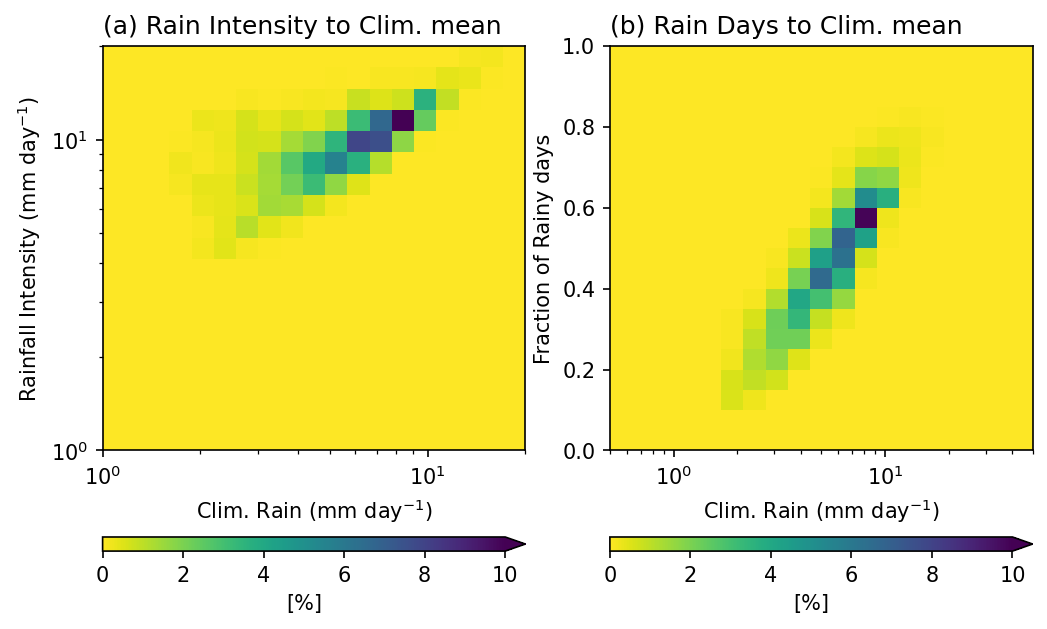

In [9]:
mpl.rcParams['figure.dpi'] = 150

fig, axes = plt.subplots(1,2,figsize=(8,5))
ax = axes.flatten()

RI_Clm_plt = RI_Clm_pdf_percent.plot.pcolormesh(x='Annual_mean_bins',y='Intensity_bins',
                                                xscale='log',yscale='log',
                                                cmap='viridis_r',ax=ax[0],
                                                vmin=0, vmax=10,
                                                extend='max',
                                                cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': r'[%]'})
ax[0].set_title('(a) Rain Intensity to Clim. mean',loc='left')
ax[0].set_ylabel(r'Rainfall Intensity (mm day$^{-1}$)')
ax[0].set_xlabel(r'Clim. Rain (mm day$^{-1}$)')

Day_Clm_plt = Days_Clm_pdf_percent.plot.pcolormesh(x='Annual_mean_bins',y='Rain_days_bins',
                                                   xscale='log',
                                                   cmap='viridis_r',ax=ax[1],
                                                   vmin=0, vmax=10,
                                                   extend='max',
                                                   cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': r'[%]'})      
ax[1].set_title('(b) Rain Days to Clim. mean',loc='left')        
ax[1].set_ylabel('Fraction of Rainy days')
ax[1].set_xlabel(r'Clim. Rain (mm day$^{-1}$)')
                                  

**Example 4: 合成平均。** 繪製8個MJO相位的降雨合成平均。

**Step 1:** 讀MJO相位資料。

In [10]:
import pandas as pd

# Read MJO data
mjo_ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.BoM/.MJO/.RMM/dods',
                         decode_times=False)

T = mjo_ds.T.values
mjo_ds['T'] = pd.date_range("1974-06-01", periods=len(T))  # Data starts from 1974-06-01

mjo_sig_phase = xr.where(mjo_ds.amplitude>=1,  mjo_ds.phase, 0).rename('mjo_phase') 
                      # Only significant (amplitude >= 1) MJO events are preserved.  
                      
mjo_slice = mjo_sig_phase.sel(T=slice("1998-01-01","2021-12-31"))
mjo_djf = mjo_slice.sel(T=mjo_slice['T'].dt.month.isin([12, 1, 2])).rename({'T':'time'})

syntax error, unexpected WORD_WORD, expecting ';' or ','
context: Attributes { T { String calendar "standard"; Int32 expires 1755820800; String standard_name "time"; Float32 pointwidth 1.0; Int32 gridtype 0; String units "julian_day"; } amplitude { Int32 expires 1755820800; String units "unitless"; Float32 missing_value 9.99999962E35; } phase { Int32 expires 1755820800; String units "unitless"; Float32 missing_value 999.0; } RMM1 { Int32 expires 1755820800; String units "unitless"; Float32 missing_value 9.99999962E35; } RMM2 { Int32 expires 1755820800; String units "unitless"; Float32 missing_value 9.99999962E35; }NC_GLOBAL { String references "Wheeler_Hendon2004"; Int32 expires 1755820800; URL Wheeler and Hendon^ (2004) Monthly Weather Review article "http://journals.ametsoc.org/doi/abs/10.1175/1520-0493(2004)132%3C1917:AARMMI%3E2.0.CO;2"; String description "Real-time Multivariate MJO Index (with components of interannual variability removed)"; URL summary from BoM "http://www.bom.go

**Step 2:** 按照MJO相位分組平均。

In [11]:
mjo_phase_comp = xarray_reduce(pcp_djf,
                               mjo_djf,
                               func='nanmean',
                               dim='time',
                               isbin=False,
                               )
mjo_phase_comp

<xarray.DataArray 'cmorph' (mjo_phase: 9, lat: 120, lon: 280)> Size: 1MB
array([[[1.5509361 , 1.5476524 , 1.5360179 , ..., 6.1897774 ,
         6.044517  , 5.838945  ],
        [1.644101  , 1.5174888 , 1.6073403 , ..., 6.6764784 ,
         6.6883655 , 6.3710103 ],
        [1.7099406 , 1.5615454 , 1.6053046 , ..., 7.1074147 ,
         7.0514264 , 6.989376  ],
        ...,
        [1.2247697 , 1.2321248 , 1.0660772 , ..., 0.9790045 ,
         0.91200596, 0.8479941 ],
        [0.9963893 , 0.90916795, 0.7632095 , ..., 1.0414264 ,
         0.996211  , 0.9376969 ],
        [0.74106985, 0.6703715 , 0.6609807 , ..., 1.0852897 ,
         1.0059881 , 0.92294204]],

       [[2.1850576 , 2.1586208 , 2.3988507 , ..., 5.4770117 ,
         4.7149425 , 4.7413793 ],
        [2.2839081 , 2.4195402 , 2.4873564 , ..., 5.5850577 ,
         4.9080462 , 5.1747127 ],
        [2.4034483 , 3.0367815 , 3.254023  , ..., 5.462069  ,
         5.521839  , 5.8977013 ],
...
        [0.2897544 , 0.26273686, 0.29249123, ..., 0.74992985,
         0.7251579 , 0.681193  ],
        [0.24196492, 0.19701755, 0.1731579 , ..., 0.7130176 ,
         0.6249825 , 0.6207018 ],
        [0.16712281, 0.14017543, 0.15249123, ..., 0.62736845,
         0.57480705, 0.5857895 ]],

       [[1.9496454 , 1.8248227 , 1.8163121 , ..., 4.546099  ,
         4.824823  , 5.4425535 ],
        [1.9907802 , 2.1276596 , 2.283688  , ..., 4.7184396 ,
         5.012766  , 5.05461   ],
        [2.555319  , 2.703546  , 2.8758867 , ..., 5.4425535 ,
         5.6014185 , 5.35461   ],
        ...,
        [0.75886524, 0.72269505, 0.57588655, ..., 3.2198582 ,
         3.0680852 , 3.1226952 ],
        [0.8056738 , 0.6815603 , 0.55602837, ..., 3.7794328 ,
         3.487234  , 3.0744681 ],
        [0.5156028 , 0.56950355, 0.5382979 , ..., 3.7475178 ,
         3.7709222 , 3.3829787 ]]], dtype=float32)
Coordinates:
  * lon        (lon) float32 1kB 90.12 90.38 90.62 90.88 ... 159.4 159.6 159.9
  * lat        (lat) float32 480B -14.88 -14.62 -14.38 ... 14.38 14.62 14.88
  * mjo_phase  (mjo_phase) float32 36B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      precipitation
    units:          mm/day
    ver_note:       1998-2020: V1,0; 2021: V0.x.
    comment:        !!! CMORPH estimate is rainrate !!!

- 在這個範例中，降雨資料 `pcp_djf` 是根據MJO相位 `mjo_djf` 分組的。對於每一組MJO相位，`func='nanmean'` 在時間軸 (`dim='time'`) 上計算平均的降雨。也就是說，所有屬於這個MJO相位的時間，都會被聚集在一起且平均。 
- `isbin=False`: 代表我們是按照 `mjo_djf` 中的相位數值 (相位1–8) 來分組的，不是另外定義的資料區間。  

**Step 3:** Plotting. 

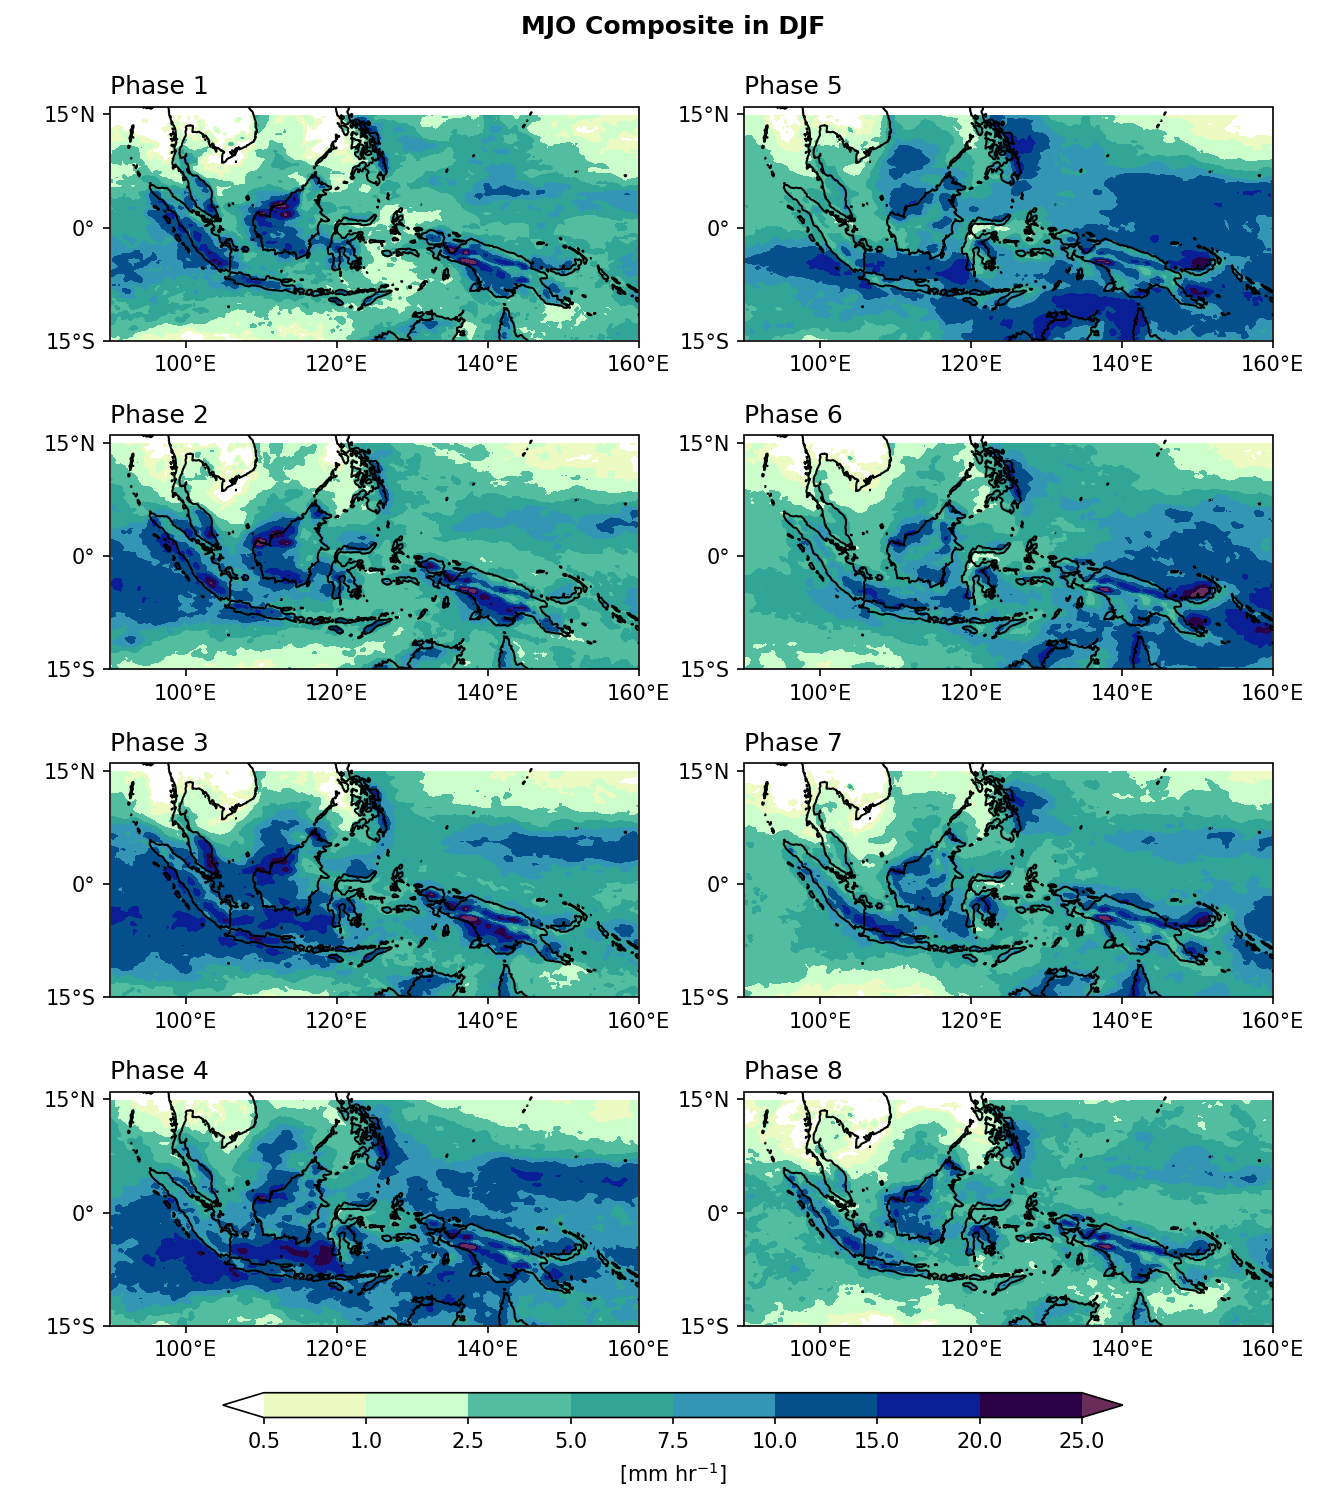

In [12]:
import cmaps
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['figure.dpi'] = 150

fig, axes = plt.subplots(4,2, 
                         subplot_kw={'projection': ccrs.PlateCarree()},
                         figsize=(10,11))
ax = axes.flatten()
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER

clevs = [0.5,1,2.5,5,7.5,10,15,20,25]

porder = [0,2,4,6,1,3,5,7]

for i in range(1,9): 
    cf = (mjo_phase_comp[i,:,:].plot.contourf(x='lon',y='lat', ax=ax[porder[i-1]],
                                         levels=clevs,
                                         add_colorbar=False,
                                         cmap=cmaps.precip_11lev, 
                                         extend='both',
                                         transform=ccrs.PlateCarree()))
    ax[porder[i-1]].coastlines()
    ax[porder[i-1]].set_extent([90,160,-15,16],crs=ccrs.PlateCarree())
    ax[porder[i-1]].set_xticks(np.arange(100,180,20), crs=ccrs.PlateCarree())
    ax[porder[i-1]].set_yticks(np.arange(-15,30,15), crs=ccrs.PlateCarree())   # 設定x, y座標的範圍，以及多少經緯度繪製刻度。
    ax[porder[i-1]].xaxis.set_major_formatter(lon_formatter)
    ax[porder[i-1]].yaxis.set_major_formatter(lat_formatter)
    ax[porder[i-1]].set_xlabel(' ')
    ax[porder[i-1]].set_ylabel(' ')
    ax[porder[i-1]].set_title(' ')
    ax[porder[i-1]].set_title('Phase '+str(i), loc='left')
    
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.015])
# Draw the colorbar 將colorbar畫在cbar_ax這個軸上。
cbar = fig.colorbar(cf, cax=cbar_ax,
                    orientation='horizontal',
                    ticks=clevs,
                    label=r'[mm hr$^{-1}$]')  

plt.subplots_adjust(hspace=0.15)
plt.suptitle('MJO Composite in DJF',y=0.92,size='large',weight='bold')
plt.show()    